In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### load file list

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# %tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

# from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers

from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#         Transformer parts       #
from keras.engine.topology import Layer
from keras.models import *
from keras.layers import *
from keras.initializers import *


### trfm model1

In [ ]:

gdrive_path = current_path

num_classes = 2

embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)

    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
        
    def get_config(self): # Needed for saving and loading model with custom layer
      config = super().get_config().copy()
      config.update({'eps': self.eps})      
      return config

# class ScaledDotProductAttention():
class ScaledDotProductAttention(Layer):
    def __init__(self, d_model, attn_dropout=0.1):
        self._name = 'ScaledDotProductAttention'
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn
        
        
    def get_config(self): # Needed for saving and loading model with custom layer
      config = super().get_config().copy()
      config.update({'temper': self.temper,
                    'dropout': self.dropout})      
      return config

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

        
    def get_config(self): # Needed for saving and loading model with custom layer
      config = super().get_config().copy()
      config.update({'mode': self.mode,
                    'n_head': self.n_head,
                    'd_k': self.d_k,
                    'd_v': self.d_v,
                    'dropout': self.dropout,
                    'attention': self.attention,
                    'layer_norm': self.layer_norm,
                    'w_o': self.w_o})      
      return config


class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask


class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

def FER_Model(input_shape):
    # first input model
    
    inp = Input(shape=input_shape, name='input')
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(32, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="sigmoid")(conc)

    net = Dense(num_classes, activation='softmax')(conc)    

    # model = Model(inputs = inp, outputs = conc)
    model = Model(inputs = inp, outputs = net)
    print(model.summary())
    
    return model

### trfm model2

In [ ]:
from multi_attention import SingleAttention,MultiAttention
from time2vector import  Time2Vector
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import numpy as np

import model
from Transformer import  TransformerEncoder



batch_size = 32
# seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256


def FER_Model(input_shape):
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(input_shape[0])
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(input_shape[0], input_shape[1]))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(2, activation='sigmoid')(x)

  model = Model(inputs=in_seq, outputs=out)
  # model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  
  return model

### all in one loop

In [ ]:
print(ohlcv['close'].pct_change().head())
print(ohlcv['close'] / ohlcv['close'].shift(1).head() - 1)

start_stamp : 0
len(ohlcv) : 18048


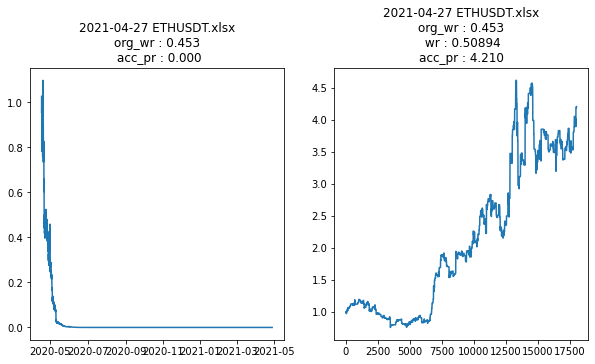

x series loaded !
y series loaded !
index series loaded !


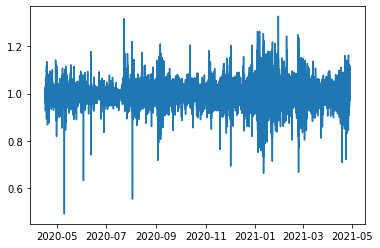

pr_thresh : 1.010425784303729
x_train.shape : (10755, 45, 5)
x_test.shape : (3586, 45, 5)
x_val.shape : (3585, 45, 5)
y_train.shape : (10755, 1)
y_test.shape : (3586, 1)
y_val.shape : (3585, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([7723, 3032])) [2.54716359 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([2603,  982])) [2.65071283 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([2593,  993])) [2.61127895 1.        ]
class_weights : {0: 0.6962967758643014, 1: 1.7735817941952507}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (10755, 2)
y_val_ohe.shape : (3585, 2)
y_test_ohe.shape : (3586, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shap

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
21/21 - 1s - loss: 0.6770 - accuracy: 0.5433 - val_loss: 0.7374 - val_accuracy: 0.4335
Epoch 2087/10000
21/21 - 1s - loss: 0.6770 - accuracy: 0.5430 - val_loss: 0.7360 - val_accuracy: 0.4368
Epoch 2088/10000
21/21 - 1s - loss: 0.6771 - accuracy: 0.5413 - val_loss: 0.7354 - val_accuracy: 0.4391
Epoch 2089/10000
21/21 - 1s - loss: 0.6765 - accuracy: 0.5475 - val_loss: 0.7377 - val_accuracy: 0.4349
Epoch 2090/10000
21/21 - 1s - loss: 0.6769 - accuracy: 0.5441 - val_loss: 0.7370 - val_accuracy: 0.4351
Epoch 2091/10000
21/21 - 1s - loss: 0.6770 - accuracy: 0.5434 - val_loss: 0.7362 - val_accuracy: 0.4363
Epoch 2092/10000
21/21 - 1s - loss: 0.6769 - accuracy: 0.5429 - val_loss: 0.7396 - val_accuracy: 0.4329
Epoch 2093/10000
21/21 - 1s - loss: 0.6774 - accuracy: 0.5428 - val_loss: 0.7360 - val_accuracy: 0.4363
Epoch 2094/10000
21/21 - 1s - loss: 0.6773 - accuracy: 0.5439 - val_loss: 0.7381 - val_accuracy: 0.4340
Epoch 2095/10000
21/21 - 1s - 

KeyboardInterrupt: ignored

In [ ]:
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

num_classes = 2
start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None


#           load saved npy & trained model        #
load_npy = True
load_model = False


seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 5

for i in range(len(candis)):

  keys = [candis[i]]

  if 'eth'.upper() not in candis[i]:
    continue

  # if 'comp'.upper() not in candis[i]:
  #   continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

        
    #       long      #
    pr = (ohlcv['close'].pct_change() - fee) * lvrg + 1    

    #       long liqudation     #
    lq = (ohlcv['low'] / ohlcv['close'].shift(1) - fee - 1) * lvrg + 1

    #       short       # <-- 이거를 단순히 minus 를 붙여도 되는걸까
    s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

    #       short liqudation     #
    # s_lq = (ohlcv['high'] / ohlcv['close'].shift(1) - fee) * lvrg + 1
    

    #       fill na with 1.0      #
    # pr = np.where(np.isnan(pr), 1, pr)
    # print(len(pr))
    # print("len(pr[np.isnan(pr)]) :", len(pr[np.isnan(pr)]))
    # print("np.sum(np.isnan(pr)) :", np.sum(np.isnan(pr)))
    
    # sliced_ohlcv = ohlcv[np.sum(np.isnan(pr))]
    # print(sliced_ohlcv.head())
    # break
    # s_pr = np.where(np.isnan(s_pr), 1, pr)
    # lq = np.where(np.isnan(lq), 1, lq)


    #       set lq      #
    # pr = np.where((pr != 1) & (lq <= 0), 0, pr)

    # print("len(pr[pr < 0]) :", len(pr[pr < 0]))
    # break

    org_wr = len(pr[pr > 1]) / len(pr[pr != 1])

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(pr))
    plt.title("%s\norg_wr : %.3f\n acc_pr : %.3f" % (key, org_wr, np.cumprod(pr)[-1]))


    #                    strat                   #

    # strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
    #                     (ohlcv['close'].shift(2) < ohlcv['close'].shift(3)), pr, 1)


    # strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
    #                     (ohlcv['close'].shift(2) > ohlcv['close'].shift(3)) & 
    #                     (ohlcv['close'].shift(3) > ohlcv['close'].shift(4)) & 
    #                     (ohlcv['close'].shift(4) < ohlcv['close'].shift(5)), pr, 1)


    strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
                        (ohlcv['close'].shift(2) > ohlcv['close'].shift(3)) & 
                        (ohlcv['close'].shift(3) > ohlcv['close'].shift(4)) & 
                        (ohlcv['close'].shift(4) < ohlcv['close'].shift(5)) & 
                        (ohlcv['close'].shift(5) < ohlcv['close'].shift(6)), pr, 1)
    
    # strat_pr = np.where((ohlcv['high'].shift(2) > ohlcv['high'].shift(3))& 
    #                     (ohlcv['close'].shift(1) > ohlcv['close'].shift(2)), pr, 1)


    wr = len(strat_pr[strat_pr > 1]) / len(strat_pr[strat_pr != 1])

    plt.subplot(122)
    plt.plot(np.cumprod(strat_pr))
    plt.title("%s\norg_wr : %.3f\n wr : %.5f\nacc_pr : %.3f" % (key, org_wr, wr, np.cumprod(strat_pr)[-1]))


    # #                  sl cut                #
    # sl_line = ohlcv['low'].rolling(250).min().shift(1)
    # # sl_line = ohlcv['low'].shift(1)

    # strat_pr_sl = np.where((strat_pr != 1) & (sl_line > ohlcv['low']), 
    #                      1 + lvrg * (sl_line / ohlcv['close'].shift(1) - 1 - fee), strat_pr)


    # wr_sl = len(strat_pr_sl[strat_pr_sl > 1]) / len(strat_pr_sl[strat_pr_sl != 1])
    # # wl_pr_ratio = np.mean(strat_pr[strat_pr > 1]) / np.mean(strat_pr[strat_pr < 1])
    # # wl_pr_ratio = np.cumprod(strat_pr[strat_pr > 1])[-1] / np.cumprod(strat_pr[strat_pr < 1])[-1]

    # plt.subplot(122)
    # plt.plot(np.cumprod(strat_pr_sl))
    # plt.title("%s\norg_pr : %.3f\n wr : %.5f\nacc_pr : %.3f" % (key, org_wr, wr_sl, np.cumprod(strat_pr_sl)[-1]))


    plt.show()
    # break

    period = 45
    # period = 5
    symbol_name = key.split(' ')[1].split('.')[0]      

    x_save_path = current_path + 'npy/' + '%s_lstm_updown_x_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
    pr_save_path = current_path + 'npy/' + '%s_lstm_updown_pr_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
    index_save_path = current_path + 'npy/' + '%s_lstm_updown_index_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)



    if not load_npy:

      from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
      from sklearn.model_selection import train_test_split
      from datetime import datetime

      from funcs_indicator import *

      def min_max_scale(npy_x):

        return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


      #       set data features : ohlc, v, ep
      time_index = ohlcv.index[np.sum(np.isnan(pr)):]

      sliced_ohlcv = ohlcv[np.sum(np.isnan(pr)):]

      #       scale with price    #
      ohlc = ohlcv.iloc[np.sum(np.isnan(pr)):, :4]      

      ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
      sar = lucid_sar(sliced_ohlcv)
      ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
      senkou1, senkou2 = ichimoku(sliced_ohlcv)

      #     min max scale   #
      vol = ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]
      # vol = sliced_ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]

      pr_list = pr[np.sum(np.isnan(pr)):]
      print("len(ohlc) :", len(ohlc))
      print("len(pr_list) :", len(pr_list))

      # break


      #       set params    #
      # period = 45
      # period = 5
      key_i = i

      plotting = True

      data_x, data_pr, data_updown = [], [], []
      data_index = []

      for i in range(period, len(ohlc)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:

          min_max = MinMaxScaler()
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          # temp_long_ep = long_ep[i - period : i]          
          temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
          temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)      

          temp_close = min_max_scale(temp_ohlc[:, [3]])    

          price_data = np.hstack((temp_ohlc, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

          if np.isnan(np.sum(price_data)):
            continue

          # print("price_data[:10] :", price_data[:10])
          # print("temp_ohlc.shape :", temp_ohlc.shape)
          # print("temp_long_ep.shape :", temp_long_ep.shape)
          # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
          # print("price_data.shape :", price_data.shape)

          if plotting:
            plt.plot(price_data)
            plt.show()

          ind_temp_ohlc = min_max_scale(temp_ohlc)
          temp_price_data = min_max_scale(price_data)
          # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))


          if plotting:

            plt.plot(ind_temp_ohlc)
            plt.show()
            plt.plot(temp_price_data)
            plt.show()

            plotting = False
          # break

          #   vol -> min_max
          temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
          
          #                   feature selection                   #        
          temp_data = np.hstack((ind_temp_ohlc, temp_vol))

          # temp_data = trial_list[trial_number]
          # temp_data = np.hstack((temp_ohlc[:, [3]], temp_ohlc[:, [1]], temp_bbw))
          # temp_data = temp_ohlc[:, [3]]
          # temp_data = ind_temp_ohlc[:, [3]]
          # temp_data = temp_close

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_index.append(time_index[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      # input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
      input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

      #     1c to 3c    #
      # input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      # input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      input_index = np.array(data_index).reshape(-1, 1)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)
      print('input_index.shape :', input_index.shape)


      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      # if prev_x is None:
      prev_x = input_x
      prev_pr = input_pr
      prev_ud = input_ud
      prev_index = input_index

      total_x = input_x
      total_pr = input_pr
      total_ud = input_ud
      total_index = input_index

      # else:
      #   total_x = np.vstack((prev_x, input_x))
      #   total_pr = np.vstack((prev_pr, input_pr))
      #   total_ud = np.vstack((prev_ud, input_ud)) 
      #   total_index = np.vstack((prev_index, input_index)) 

      #   prev_x = total_x
      #   prev_pr = total_pr
      #   prev_ud = total_ud
      #   prev_index = total_index

      print('total_x.shape :', total_x.shape)
      print('total_pr.shape :', total_pr.shape)
      print('total_ud.shape :', total_ud.shape)
      print('prev_index.shape :', prev_index.shape)


      # _, row, col, _ = input_x.shape
      # _, row, col = input_x.shape

      #       split new test      #

      seed = 1
      random_state = 201
      np.random.seed(seed)
      from sklearn.model_selection import train_test_split


      #         get unique timestamp      #
      print(np.unique(total_index, return_counts=True))
      uniq_stamp = np.unique(total_index)

      #                 don't shuffle timeseries data                 #
      stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
      stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=False, random_state=random_state)

      print("stamp_train.shape :", stamp_train.shape)
      print("stamp_val.shape :", stamp_val.shape)
      print("stamp_test.shape :", stamp_test.shape)
      # break


      #         split data by stamp     #
      x_train, x_val, x_test = [], [], []
      pr_train, pr_val, pr_test = [], [], []
      index_train, index_val, index_test = [], [], []


      from tqdm.notebook import tqdm

      # np.random.shuffle(total_index)

      for i in tqdm(range(len(total_index))):

        if total_index[i] in stamp_train:
          x_train.append(total_x[i])
          pr_train.append(total_pr[i])
          index_train.append(total_index[i])

        elif total_index[i] in stamp_val:
          x_val.append(total_x[i])
          pr_val.append(total_pr[i])
          index_val.append(total_index[i])
        
        elif total_index[i] in stamp_test:
          x_test.append(total_x[i])
          pr_test.append(total_pr[i])
          index_test.append(total_index[i])


      x_train = np.array(x_train)
      x_val = np.array(x_val)
      x_test = np.array(x_test)

      pr_train = np.array(pr_train)
      pr_val = np.array(pr_val)
      pr_test = np.array(pr_test)

      index_train = np.array(index_train)
      index_val = np.array(index_val)
      index_test = np.array(index_test)
        
      print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)


      np.save(x_save_path, x_train)
      np.save(x_save_path.replace('x_train', 'x_val'), x_val)
      np.save(x_save_path.replace('x_train', 'x_test'), x_test)
      # np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
      print('x series saved !')

      np.save(pr_save_path, pr_train)
      np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
      np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
      # np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
      print('pr series saved !')
      
      np.save(index_save_path, index_train)
      np.save(index_save_path.replace('index_train', 'index_val'), index_val)
      np.save(index_save_path.replace('index_train', 'index_test'), index_test)
      print('index series saved !')

    else:
      
      x_train = np.load(x_save_path)
      x_val = np.load(x_save_path.replace('x_train', 'x_val'))
      x_test = np.load(x_save_path.replace('x_train', 'x_test'))
      print('x series loaded !')


      pr_train = np.load(pr_save_path)
      pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
      pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
      print('y series loaded !')


      index_train = np.load(index_save_path, allow_pickle=True)
      index_val = np.load(index_save_path.replace('index_train', 'index_val'), allow_pickle=True)
      index_test = np.load(index_save_path.replace('index_train', 'index_test'), allow_pickle=True)
      print('index series loaded !')




    #       pr_thresh by percentage 0.285     #
    plt.plot(pr)
    plt.show()
    
    sorted_pr = sorted(pr, reverse=True)
    pct = 0.28
    len_pct = int(len(pr) * pct)
    pr_thresh = sorted_pr[len_pct]
    print("pr_thresh :", pr_thresh)

    from keras.utils import np_utils

    # from keras.preprocessing.image import ImageDataGenerator 
    from sklearn.utils import class_weight


    def class_ratio(in_list):

      return in_list / in_list[1]
      
    y_train = np.where(pr_train > pr_thresh, 1, 0)
    y_test = np.where(pr_test > pr_thresh, 1, 0)
    y_val = np.where(pr_val > pr_thresh, 1, 0)

    print('x_train.shape :', x_train.shape)
    print('x_test.shape :', x_test.shape)
    print('x_val.shape :', x_val.shape)
    print('y_train.shape :', y_train.shape)
    print('y_test.shape :', y_test.shape)
    print('y_val.shape :', y_val.shape)

    # try:
    print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
    print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
    print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

    # except Exception as e:
      # print(e)

    label = y_train.reshape(-1, )
    class_weights = class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(label),
                                                        y=label)
    class_weights = dict(enumerate(class_weights))
    print('class_weights :', class_weights)

    # sample_weight = np.ones(shape=(len(y_train),))
    # sample_weight[(y_train == 1).reshape(-1,)] = 1.5
    # print('sample_weight[:20] :', sample_weight[:20])


    print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
    print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
    print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

    print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
    print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
    print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

    y_train_ohe = np_utils.to_categorical(y_train, num_classes)
    y_val_ohe = np_utils.to_categorical(y_val, num_classes)
    y_test_ohe = np_utils.to_categorical(y_test, num_classes)
    print('y_train_ohe.shape :', y_train_ohe.shape)
    print('y_val_ohe.shape :', y_val_ohe.shape)
    print('y_test_ohe.shape :', y_test_ohe.shape)
    

    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'

    batch_size = 512

    K.clear_session()

    model_name = 'classifier_%s_trfm1_updown_rascend_%s_%s_tvnon_shuffle.h5' % (period, int(pct * 1000), symbol_name)


    if not load_model:

      from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

      model = FER_Model(input_shape=x_train.shape[1:])
      opt = Adam(lr=1e-5, decay=5e-6)
      # opt = Adam(lr=0.001, decay=0.0005)
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
      checkpoint2 = TensorBoard(log_dir=board_path,
                                histogram_freq=0,
                                write_graph=True,
                                write_images=True)
      checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
      callbacks_list = [checkpoint, checkpoint2, checkpoint3]
      # callbacks_list = [checkpoint, checkpoint2]

      # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

      # we iterate 200 times over the entire training set
      num_epochs = 10000
      history = model.fit(x_train, y_train_ohe, 
                          steps_per_epoch=len(x_train) / batch_size, 
                          epochs=num_epochs,  
                          verbose=2,  
                          # callbacks=callbacks_list,
                          class_weight=class_weights,
                          validation_data=(x_val, y_val_ohe),  
                          validation_steps=len(x_val) / batch_size,
                          shuffle=False)
      
    
    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'

    model.save(ckpt_path + model_name)
    
    model = keras.models.load_model(ckpt_path + model_name)

    test_result = model.predict(x_test)
    # test_result = model.predict(test_set)

    print('test_result.shape :', test_result.shape)
    # print('pr_val.shape :', pr_val.shape)

    y_score = test_result[:, [1]]
    print('y_test[:5] :', y_test.reshape(-1,)[:5])
    # print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
    print('y_score[:5] :', y_score[:5])
    # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

    print('y_test.shape :', y_test.shape)
    print('y_score.shape :', y_score.shape)

    print('len(y_test) :', len(y_test))

    #     precision recall curve   #
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    precision, recall = precision[:-1], recall[:-1]

    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    plt.show()
    # print(y_pred)


    # threshold = [0.65]
    # print('threshold :', threshold)
    # break

    acc_pr_bythr = []
    new_thresh = []

    for thresh in threshold:
      
      # if thresh < 0.5:
      #     continue

      y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
      # print('y_pred.shape :', y_pred.shape)
      # print('y_pred :', y_pred)

      #     compare precision     #

      # print('precision :', precision_score(y_test, y_pred))
      # print('recall :', recall_score(y_test, y_pred))
      # print()

      # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
      # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

      # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
      # # plt.show()  
      # print()

      #     check win-ratio improvement     #
      cmat = confusion_matrix(y_test, y_pred)
      # print(cmat)
      # print(np.sum(cmat, axis=1))

      test_size = len(y_test)
      test_pr_list = pr_test
      # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

      org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
      ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
      # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

      # print('pr_test.shape :', pr_test.shape)

      # print(y_pred)
      # print(test_pr_list)

      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
      # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
      # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
      # print('pred_pr_list.shape :', pred_pr_list.shape)

      # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
      #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
      #   print('thresh :', thresh)
        
      # if len(threshold) == 1:
    #   plt.figure(figsize=(10, 5))
    #   plt.subplot(121)
    #   plt.plot(np.cumprod(test_pr_list))
    #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
    # # plt.show()

    #   plt.subplot(122)
    #   plt.plot(np.cumprod(pred_pr_list))
    #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
    #   plt.show()


      acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
      new_thresh.append(thresh)


    print('acc_pr_bythr :', acc_pr_bythr)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    # plt.show()
    plt.subplot(122)
    plt.plot(new_thresh, acc_pr_bythr)
    plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
    plt.title(symbol_name)
    plt.show()
          



### save npy

In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from funcs_indicator import *

def min_max_scale(npy_x):

  return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


#       set data features : ohlc, v, ep
time_index = ohlcv.index[np.sum(np.isnan(pr)):]

sliced_ohlcv = ohlcv[np.sum(np.isnan(pr)):]

#       scale with price    #
ohlc = ohlcv.iloc[np.sum(np.isnan(pr)):, :4]      

ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
sar = lucid_sar(sliced_ohlcv)
ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
senkou1, senkou2 = ichimoku(sliced_ohlcv)

#     min max scale   #
vol = sliced_ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]

pr_list = pr[np.sum(np.isnan(pr)):]
print("len(ohlc) :", len(ohlc))
print("len(pr) :", len(pr))

# break


#       set params    #
period = 45
key_i = i

plotting = True

data_x, data_pr, data_updown = [], [], []
data_index = []

for i in range(period, len(ohlc)):

  #   pr_list != 1 인 데이터만 사용한다
  # if 1:
  if pr_list[i] != 1:

    min_max = MinMaxScaler()
    
    #   prediction 을 제외한 이전 데이터를 사용해야한다
    temp_ohlc = ohlc.iloc[i - period : i].values
    # temp_long_ep = long_ep[i - period : i]          
    temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
    temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
    temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
    temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)      

    temp_close = min_max_scale(temp_ohlc[:, [3]])    

    price_data = np.hstack((temp_ohlc, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

    if np.isnan(np.sum(price_data)):
      continue

    # print("price_data[:10] :", price_data[:10])
    # print("temp_ohlc.shape :", temp_ohlc.shape)
    # print("temp_long_ep.shape :", temp_long_ep.shape)
    # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
    # print("price_data.shape :", price_data.shape)

    if plotting:
      plt.plot(price_data)
      plt.show()

    ind_temp_ohlc = min_max_scale(temp_ohlc)
    temp_price_data = min_max_scale(price_data)
    # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))


    if plotting:

      plt.plot(ind_temp_ohlc)
      plt.show()
      plt.plot(temp_price_data)
      plt.show()

      plotting = False
    # break

    #   vol -> min_max
    temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
    
    #                   feature selection                   #        
    temp_data = np.hstack((ind_temp_ohlc, temp_vol))

    # temp_data = trial_list[trial_number]
    # temp_data = np.hstack((temp_ohlc[:, [3]], temp_ohlc[:, [1]], temp_bbw))
    # temp_data = temp_ohlc[:, [3]]
    # temp_data = ind_temp_ohlc[:, [3]]
    # temp_data = temp_close

    if np.isnan(np.sum(temp_data)):
      continue

    data_x.append(temp_data)
    data_pr.append(pr_list[i])
    data_index.append(time_index[i])
    data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


print('np.array(data_x).shape :', np.array(data_x).shape)
# print(data_x[0])


#       Reshape data for image deep - learning     #
_, row, col = np.array(data_x).shape

input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
# input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

#     1c to 3c    #
input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
# input_x = np.array(resize_npy(input_x))


input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
input_index = np.array(data_index).reshape(-1, 1)
print('input_x.shape :', input_x.shape)
print('input_x.dtype :', input_x.dtype)
print('input_pr.shape :', input_pr.shape)
print('input_ud.shape :', input_ud.shape)
print('input_index.shape :', input_index.shape)


# x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
# x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

#     do stacking   #
# if prev_x is None:
prev_x = input_x
prev_pr = input_pr
prev_ud = input_ud
prev_index = input_index

total_x = input_x
total_pr = input_pr
total_ud = input_ud
total_index = input_index

# else:
#   total_x = np.vstack((prev_x, input_x))
#   total_pr = np.vstack((prev_pr, input_pr))
#   total_ud = np.vstack((prev_ud, input_ud)) 
#   total_index = np.vstack((prev_index, input_index)) 

#   prev_x = total_x
#   prev_pr = total_pr
#   prev_ud = total_ud
#   prev_index = total_index

print('total_x.shape :', total_x.shape)
print('total_pr.shape :', total_pr.shape)
print('total_ud.shape :', total_ud.shape)
print('prev_index.shape :', prev_index.shape)


# _, row, col, _ = input_x.shape
# _, row, col = input_x.shape

#       split new test      #

seed = 1
random_state = 201
np.random.seed(seed)
from sklearn.model_selection import train_test_split


#         get unique timestamp      #
print(np.unique(total_index, return_counts=True))
uniq_stamp = np.unique(total_index)

#                 don't shuffle timeseries data                 #
stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=False, random_state=random_state)

print("stamp_train.shape :", stamp_train.shape)
print("stamp_val.shape :", stamp_val.shape)
print("stamp_test.shape :", stamp_test.shape)
# break


#         split data by stamp     #
x_train, x_val, x_test = [], [], []
pr_train, pr_val, pr_test = [], [], []
index_train, index_val, index_test = [], [], []


from tqdm.notebook import tqdm

np.random.shuffle(total_index)

for i in tqdm(range(len(total_index))):

  if total_index[i] in stamp_train:
    x_train.append(total_x[i])
    pr_train.append(total_pr[i])
    index_train.append(total_index[i])

  elif total_index[i] in stamp_val:
    x_val.append(total_x[i])
    pr_val.append(total_pr[i])
    index_val.append(total_index[i])
  
  elif total_index[i] in stamp_test:
    x_test.append(total_x[i])
    pr_test.append(total_pr[i])
    index_test.append(total_index[i])


x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

pr_train = np.array(pr_train)
pr_val = np.array(pr_val)
pr_test = np.array(pr_test)

index_train = np.array(index_train)
index_val = np.array(index_val)
index_test = np.array(index_test)
  
print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

symbol_name = key.split(' ')[1].split('.')[0]

x_save_path = current_path + 'npy/' + '%s_cnn_updown_x_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
pr_save_path = current_path + 'npy/' + '%s_cnn_updown_pr_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)

np.save(x_save_path, x_train)
np.save(x_save_path.replace('x_train', 'x_val'), x_val)
np.save(x_save_path.replace('x_train', 'x_test'), x_test)
# np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
print('x series saved !')

np.save(pr_save_path, pr_train)
np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
# np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
print('pr series saved !')
      

In [ ]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

### load npy

In [ ]:
from keras.utils import np_utils

# from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight


symbol_name = "SXPUSDT"
period = 45

x_save_path = current_path + 'npy/' + '%s_cnn_updown_x_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
pr_save_path = current_path + 'npy/' + '%s_cnn_updown_pr_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)


x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')


pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

# total_x = np.vstack((x_train, x_val, x_test))
# total_pr = np.vstack((pr_train, pr_val, pr_test))

# print("total_x.shape :", total_x.shape)

x series loaded !
y series loaded !


### rapid pr selection

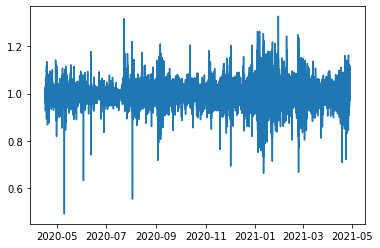

0.36131427304964536


In [ ]:
plt.plot(pr)
plt.show()

pr_thresh = 1.005
rapid_pct = len(pr[pr > pr_thresh]) / len(pr)

print(rapid_pct)

### class_weight & categorization

In [ ]:
from keras.utils import np_utils

# from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight


def class_ratio(in_list):

  return in_list / in_list[1]
  
y_train = np.where(pr_train > pr_thresh, 1, 0)
y_test = np.where(pr_test > pr_thresh, 1, 0)
y_val = np.where(pr_val > pr_thresh, 1, 0)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

# try:
print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

# except Exception as e:
  # print(e)

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)

x_train.shape : (10755, 45, 5, 3)
x_test.shape : (3586, 45, 5, 3)
x_val.shape : (3585, 45, 5, 3)
y_train.shape : (10755, 1)
y_test.shape : (3586, 1)
y_val.shape : (3585, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([6864, 3891])) [1.76407093 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([2303, 1282])) [1.79641186 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([2291, 1295])) [1.76911197 1.        ]
class_weights : {0: 0.7834353146853147, 1: 1.382035466461064}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (10755, 2)
y_val_ohe.shape : (3585, 2)
y_test_ohe.shape : (3586, 2)


### augment

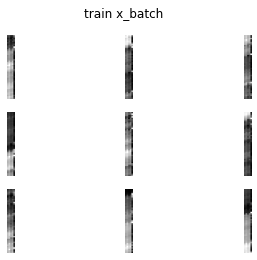

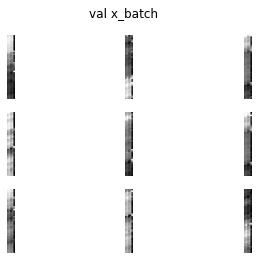

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator( 
    # rotation_range = 45,
    # zoom_range = 0.5,
    # shear_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    # fill_mode = 'nearest'
    )

valgen = ImageDataGenerator( 
    )

datagen.fit(x_train)
valgen.fit(x_val)


batch_size = 512


for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

    plt.suptitle("train x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break

for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

    plt.suptitle("val x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break
    
train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
# break

### train

In [ ]:

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'

# batch_size = 512

model = FER_Model(input_shape=x_train.shape[1:])
opt = Adam(lr=0.00001, decay=0.000005)
# opt = Adam(lr=0.001, decay=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_name = 'classifier_%s_cnn_updown_rascend_1005_%s_tvnon_shuffle.h5' % (period, symbol_name)



checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]
# callbacks_list = [checkpoint, checkpoint2]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(x_val) / batch_size,
                    shuffle=False)

### load model

In [ ]:
ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'


model_name = 'classifier_%s_cnn_updown_rascend_101_%s_tvnon_shuffle.h5' % (period, symbol_name)


model = keras.models.load_model(ckpt_path + model_name)

### test

test_result.shape : (3586, 2)
y_test[:5] : [0 1 0 0 0]
y_score[:5] : [[0.63237864]
 [0.7486433 ]
 [0.76785046]
 [0.7782063 ]
 [0.7413408 ]]
y_test.shape : (3586, 1)
y_score.shape : (3586, 1)
len(y_test) : 3586


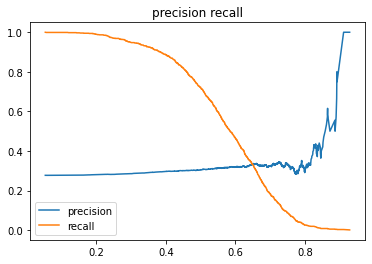

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in long_scalars


acc_pr_bythr : [5.6357174e-05, 5.5886154e-05, 5.67158e-05, 5.6669294e-05, 5.7091907e-05, 5.7512967e-05, 5.7127658e-05, 5.76002e-05, 5.720071e-05, 5.7092424e-05, 5.6980574e-05, 5.555421e-05, 5.5877998e-05, 5.5956312e-05, 5.7183424e-05, 5.7088255e-05, 5.8180467e-05, 5.847948e-05, 5.6607638e-05, 5.6740617e-05, 5.730362e-05, 5.6770943e-05, 5.613658e-05, 5.7306817e-05, 5.7943013e-05, 5.7534253e-05, 5.798392e-05, 5.775454e-05, 5.820831e-05, 5.834451e-05, 5.7173118e-05, 5.7775767e-05, 5.8676822e-05, 5.8725793e-05, 5.8399768e-05, 5.8395242e-05, 5.9080092e-05, 6.1325525e-05, 6.0857572e-05, 6.108424e-05, 6.142279e-05, 6.192488e-05, 6.180024e-05, 6.2271254e-05, 6.1912055e-05, 5.8304107e-05, 5.8736336e-05, 5.862884e-05, 6.0744456e-05, 6.059862e-05, 6.146693e-05, 6.0837672e-05, 6.1054416e-05, 6.161579e-05, 6.18798e-05, 6.30495e-05, 6.244632e-05, 6.2524465e-05, 6.343934e-05, 6.191188e-05, 6.330675e-05, 6.563254e-05, 6.601831e-05, 6.551173e-05, 6.6703135e-05, 6.584157e-05, 6.5173335e-05, 6.6615874e-0

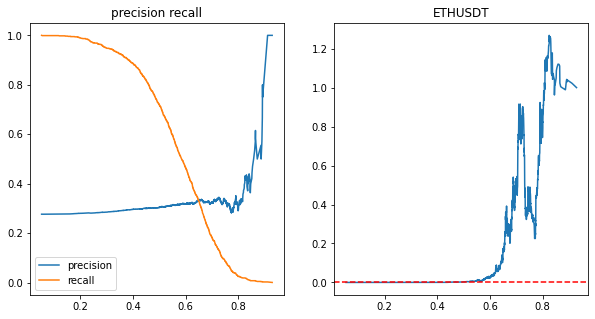

In [ ]:
test_result = model.predict(x_test)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
# print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


# threshold = [0.65]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
new_thresh = []

for thresh in threshold:
  
  # if thresh < 0.5:
  #     continue

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  # print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  # print('precision :', precision_score(y_test, y_pred))
  # print('recall :', recall_score(y_test, y_pred))
  # print()

  # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # # plt.show()  
  # print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)

  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
  # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
  #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
  #   print('thresh :', thresh)
    
  # if len(threshold) == 1:
#   plt.figure(figsize=(10, 5))
#   plt.subplot(121)
#   plt.plot(np.cumprod(test_pr_list))
#   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
# # plt.show()

#   plt.subplot(122)
#   plt.plot(np.cumprod(pred_pr_list))
#   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
#   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
#   plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
  new_thresh.append(thresh)


print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.title(symbol_name)
plt.show()

In [ ]:
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.axvline(new_thresh[np.argmax(acc_pr_bythr)], linestyle='--', color='r')
plt.title(symbol_name + '\n' + str(new_thresh[np.argmax(acc_pr_bythr)]))
plt.show()

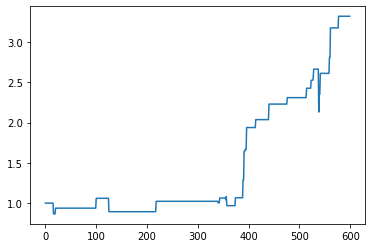

In [ ]:
thresh = 0.5866
y_pred = np.where(y_score[:600, -1] > thresh, 1, 0)
# print('y_pred.shape :', y_pred.shape)
# print('y_pred :', y_pred)

#     compare precision     #

# print('precision :', precision_score(y_test, y_pred))
# print('recall :', recall_score(y_test, y_pred))
# print()

# print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
# print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

# # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
# # plt.show()  
# print()

#     check win-ratio improvement     #
cmat = confusion_matrix(y_test[:len(y_pred)], y_pred)
# print(cmat)
# print(np.sum(cmat, axis=1))

test_size = len(y_test[:len(y_pred)])
test_pr_list = pr_test[:len(y_pred)]
# print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
# print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

# print('pr_test.shape :', pr_test.shape)

# print(y_pred)
# print(test_pr_list)
pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)

plt.plot(np.cumprod(pred_pr_list))
plt.show()

In [ ]:
min_max = MinMaxScaler()
cbo1 = min_max.fit_transform(cbo.values.reshape(-1, 1))
bbw1 = min_max.fit_transform(bbw.values.reshape(-1, 1))

min_max = MinMaxScaler()
bbw2 = min_max.fit_transform(bbw.values.reshape(-1, 1))

print(bbw1[-10:])
print(bbw2[-10:])
plt.plot(bbw1)
plt.plot(bbw2)

plt.show()

print(len(bbw1))

### Check shuffled index

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

NameError: ignored

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

